# Notebook: histoRAG, Eval German with document index of 500

This notebook evaluates the historical RAG model analogue to the English evaluation with 500 documents.
(code is the same as RAG 3.1 but with a random subsample of 500 docs)

# 0. Install libraries

In [ ]:
!pip install -qU openai cohere faiss-cpu langchain langchain-community tiktoken==0.5.2 langchain_openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.9/312.9 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.6/867.6 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.7/116.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

# 1. Create a vectorstore
A vector store is neccessary for the retrieval part of the model. This consists of text parts from the fed-in sources and later serves as a knowledge base for the retriever.

In [ ]:
## mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In the next step, an embedding model is initiated (here: `text-embedding-ada-002` from [OpenAI](https://openai.com/blog/new-and-improved-embedding-model)).

In [ ]:
# setup embedding model
import os
from getpass import getpass
from langchain_openai import OpenAIEmbeddings
from google.colab import userdata

# get API key
secret = getpass("Enter your OpenAI API key: ")
OPENAI_API_KEY = secret
model_name = 'text-embedding-ada-002'

embeddings = OpenAIEmbeddings(
    model=model_name,
    openai_api_key=OPENAI_API_KEY
)

## Build a new index
When sources are used for the first time, the vector store is newly created. To do this, the text file is first read in and then split into chunks.

In [ ]:
# path to folder containing the .txt files
folder_path = "../data/source_documents_TXT"

# Key: file name, Value: file content
data = {}

# iterate through all files
for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    with open(file_path, 'r', encoding='utf-8') as file:
        data[file_name] = file.read()

In [ ]:
from langchain.text_splitter import CharacterTextSplitter

text_splitter = CharacterTextSplitter(chunk_size = 1000, chunk_overlap=200, separator='')

In [ ]:
# build the docs from the file dict
docs = []

# lists for texts and their corresponding metadata
texts = []
metadatas = []

# iterate over each file and its content in the data dict
for file_name, text_content in data.items():
    # add content
    texts.append(text_content)
    # create a metadata dict and add it
    metadatas.append({'filename': file_name})

# create docs
docs = text_splitter.create_documents(texts, metadatas)

next: take random sample of 500 chunks to match the length of the English evaluation

In [ ]:
# take random subsample
import random

sample = random.sample(docs, 500)

In [ ]:
# set subsample as docs
docs = sample

----

In [ ]:
# did it work?
print(docs[3], '\n', docs[7])
print(len(docs))

page_content='rich Ponto als Dr. Schwedinger. Ferner Margarete Schön, Hildegard Grethe, Hedwig Bleibtreu, Schroth, Goetzke, Steinbeck usw. Mit dem Kameramann Fritz Arno Wagner stand Liebeneiner ein trefflicher Mitarbeiter zur Seite. Milieu und Atmosphäre der damaligen Zeit werden uns durch Wagners künstlerische Bildgestaltung nahe gebracht. Herbert Windt beteute den Film musikalisch und schuf neben Verwendung bekannter Märsche der Kaiserzeit eigene Kompositionen, die die Spannungsmomente noch steigern. Emil Jannings in Konzerts 6ss Musikstücken in übermütigem - Jannings - Jammel des Podis „vis Knallsong" ummünzte. Und schon erleben wir die Wirkungen dieses Krieges in einer weiteren Vertiefung der Gemeinschaftsidee und über die Grenzen hinaus die Geburt eines neuen Europa. Wo aber der junge Dichter heute zunächst einmal als Mensch stehen muss, damit das gewaltige Geschehen dieses Krieges in einer echten Dichtung später gedeutet werden kann, das sprach der als Bataillonsführer verwundete

**Note**: The CharacterTextSplitter is a very simple type of splitting. Other options are:
- SemanticChunker:
  https://python.langchain.com/docs/modules/data_connection/document_transformers/semantic-chunker
- ParentDocument retriever: https://python.langchain.com/docs/modules/data_connection/retrievers/parent_document_retriever; https://www.youtube.com/watch?v=07H-om5lj-s&t=131s


Using the embedding model, the individual chunks are converted into embeddings and loaded into a [FAISS](https://faiss.ai/index.html) store using [LangChain](https://python.langchain.com/docs/integrations/vectorstores/faiss).

In [ ]:
# setup FAISS store
from langchain.vectorstores import FAISS

# storing embeddings in the vector store
vectorstore = FAISS.from_documents(docs, embeddings)

---

# 2. Build the RAG model
The RAG model will be built next. A workflow is defined using [LangChain](https://python.langchain.com/docs/get_started/introduction).

First, the vectorstore created above is initialised as a retriever.

To include the dialogue story in the chat, a prompt template is defined and converted into a `PromptTemplate` object. In this template, the dialogue history is merged with the current question.

In [ ]:
from langchain.prompts.prompt import PromptTemplate

retriever = vectorstore.as_retriever()

_template = """Formuliere den folgenden Dialog und die follow-up Frage so um, dass sie eine eigenständige Frage ist, und zwar in der Originalsprache.

Dialoggeschichte:
{chat_history}
follow-up Frage: {question}
eigenständige Frage:"""
CONDENSE_QUESTION_PROMPT = PromptTemplate.from_template(_template)

In a further prompt, the context (the documents retrieved from the KB) is summarised in an instruction with the query in order to be transferred together to the LLM, that gives the final answer.

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

template = """Beantworte die Frage basierend alleinig auf dem folgenden Kontext:
{context}

Frage: {question}
"""
ANSWER_PROMPT = ChatPromptTemplate.from_template(template)

For the `context` variable, we need the content of the retrieved documents as text. To do this, we write a function that takes the documents, a template to get the `page_content` and a separator and returns the joined texts.

In [ ]:
from langchain.schema import format_document

DEFAULT_DOCUMENT_PROMPT = PromptTemplate.from_template(template="{page_content}")

def _combine_documents(
    docs, document_prompt=DEFAULT_DOCUMENT_PROMPT, document_separator="\n\n"
):
    doc_strings = [format_document(doc, document_prompt) for doc in docs]
    return document_separator.join(doc_strings)

### Now we put the chain together (fist with an empty `chat_history`).
Docs for the used Runnables:
- [RunnableParallel](https://python.langchain.com/docs/expression_language/how_to/map)
- [RunnablePassthrough](https://python.langchain.com/docs/expression_language/how_to/passthrough)

**1. Integrate the dialog history with `_inputs`:**  
- `RunnableParallel()` manipulates the output so that it fits as input into the next runnable of the sequence (here: `CONDENSE_QUESTION_PROMPT`)
- `RunnablePassthrough()` is used to pass the `chat_history` to the input as a further argument
- the `CONDENSE_QUESTION_PROMPT` applies the template defined above
- this is sent to `ChatOpenAI()`
- the output is formatted as a string with `StrOutputParser()`

**2. Build `_context` from:**
1. The documents that are found with the retriever. The search input for this is the `standalone_question`.
> `itemgetter` is a shorthand to extract data from the map (see [Python Docu](https://docs.python.org/3/library/operator.html#operator.itemgetter)).
2. And `question`, which was converted to the `standalone_question` together with the dialogue history.


**3. Put the `conversational_qa_chain` together from:**
- `_inputs`
- `_context`
- the `ANSWER_PROMPT` from above
- and the LLM to which all the information in this prompt is passed.


In [ ]:
from langchain_core.runnables import RunnableParallel, RunnablePassthrough
from langchain_core.messages import AIMessage, HumanMessage, get_buffer_string
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter

_inputs = RunnableParallel(
    standalone_question=RunnablePassthrough.assign(
        chat_history=lambda x: get_buffer_string(x["chat_history"])
    )
    | CONDENSE_QUESTION_PROMPT
    | ChatOpenAI(openai_api_key=OPENAI_API_KEY, temperature=0)
    | StrOutputParser(),
)
_context = {
    "context": itemgetter("standalone_question") | retriever | _combine_documents,
    "question": lambda x: x["standalone_question"],
}
conversational_qa_chain = _inputs | _context | ANSWER_PROMPT | ChatOpenAI(openai_api_key=OPENAI_API_KEY)

We start the chain with a question and an initially empty chat history:

In [ ]:
conversational_qa_chain.invoke(
    {
        "question": "Was will Friederike mit ihrer Freundin Gudrun machen?",
        "chat_history": []
    }
)

AIMessage(content='Friederike und ihre Freundin Gudrun haben vor, nach Hause zu gehen und sich dort zu entspannen, während Gudrun ein Buch von Margarete Kurlbaum-Siebert liest.', response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 1220, 'total_tokens': 1266}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_a450710239', 'finish_reason': 'stop', 'logprobs': None}, id='run-6bd5d15c-c35c-441b-9d01-a4761e66f4dc-0')

Looks good! Now let's add the actual chat_history to the chain:

In [ ]:
from langchain.memory import ConversationBufferMemory

memory = ConversationBufferMemory(
    return_messages=True, output_key="answer", input_key="question"
)

In [ ]:
print(memory)

output_key='answer' input_key='question' return_messages=True


The final chain is assembled.
Docs for the runnables:
[RunnableLambda](https://python.langchain.com/docs/expression_language/how_to/functions)
1. We add one step to `loaded_memory` and add the **history**.
2. `standalone_question` is formed using the current `question` and `chat_history`, both sent to the LLM with the `CONDENSE_QUESTION_PROMPT`.
3. Retrieve the documents with the `standalone_question` and the retriever.
4. Assemble the inputs for the `ANSWER_PROMPT`.
5. Define the answer as the output of the LLM to the `ANSWER_PROMPT` plus the documents used.
6. Put everything together in a final chain.

In [ ]:
from langchain_core.runnables import RunnableLambda, RunnablePassthrough

# 1. add memory
loaded_memory = RunnablePassthrough.assign(
    chat_history=RunnableLambda(memory.load_memory_variables) | itemgetter("history"),
)

# 2. calc the standalone_question
standalone_question = {
    "standalone_question": {
        "question": lambda x: x["question"],
        "chat_history": lambda x: get_buffer_string(x["chat_history"]),
    }
    | CONDENSE_QUESTION_PROMPT
    | ChatOpenAI(openai_api_key=OPENAI_API_KEY, temperature=0)
    | StrOutputParser(),
}

# 3. retrieve the docs
retrieved_documents = {
    "docs": itemgetter("standalone_question") | retriever,
    "question": lambda x: x["standalone_question"],
}

# 4. put the final_inputs together
final_inputs = {
    "context": lambda x: _combine_documents(x["docs"]),
    "question": itemgetter("question"),
}

# 5. define answer structure
answer = {
    "answer": final_inputs | ANSWER_PROMPT | ChatOpenAI(openai_api_key=OPENAI_API_KEY),
    "docs": itemgetter("docs"),
}

# 6. put everything together
final_chain = loaded_memory | standalone_question | retrieved_documents | answer

Let's test it

In [ ]:
# inputs = {"question": "Was will Friederike mit ihrer Freundin Gudrun machen?"}
# result = final_chain.invoke(inputs)
# result

{'answer': AIMessage(content='Friederike und ihre Freundin Gudrun planen, sich in Freiburg zu treffen, um gemeinsam im Schwarzwald zu wandern.', response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 1215, 'total_tokens': 1248}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_b28b39ffa8', 'finish_reason': 'stop', 'logprobs': None}, id='run-e03dd9db-fede-4adc-aab1-c1bf0eff6548-0'),
 'docs': [Document(page_content='t ein selbstverständliches Verhältnis herstellte. Die zweite Mutter jedoch vermochte der Seele des Mädchens nicht nahe zu kommen.\n\nNun, im Sommer 1914, war Friederike zwanzig Jahre alt. Zu dieser Zeit erwachte in ihr der Wunsch, einmal eine selbständige Reise ganz ohne ihre Familie zu machen. Sie wollte sich mit ihrer Freundin Gudrun von Falkenthal, die in Freiburg im Breisgau Medizin studierte, treffen, um von dort im Schwarzwald zu wandern.\n\nAls Friederike in Freiburg ankam, sprang sie aus dem Zug, um der Freundin entgegenzueilen. „Oh du, d

It works!
As memory does not save automatically, we have to add this step after each turn:

In [ ]:
# memory.save_context(inputs, {"answer": result["answer"].content})

## Check the memory
Test: whats the dialog history?

In [ ]:
# # check the saved memory
# memory.load_memory_variables({})

{'history': [HumanMessage(content='Was will Friederike mit ihrer Freundin Gudrun machen?'),
  AIMessage(content='Friederike und ihre Freundin Gudrun planen, sich in Freiburg zu treffen, um gemeinsam im Schwarzwald zu wandern.')]}

In [ ]:
inputs = {"question": "Was erleben sie auf ihrem Ausflug?"}
result = final_chain.invoke(inputs)
result

{'answer': AIMessage(content='Friederike und Gudrun erkunden die Stadt Freiburg, besuchen den alten Karlsfriedhof, steigen zum Schloßberg hinauf, essen in einer Wirtschaft am Ufer und genießen den Ausblick über die Stadt. Sie erleben eine angenehme Sommernacht und beobachten die Stadt im festlichen Lichterschmuck.', response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 1210, 'total_tokens': 1292}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_b28b39ffa8', 'finish_reason': 'stop', 'logprobs': None}, id='run-db3f6a06-5ef7-4782-8d40-55689a923cfc-0'),
 'docs': [Document(page_content='t ein selbstverständliches Verhältnis herstellte. Die zweite Mutter jedoch vermochte der Seele des Mädchens nicht nahe zu kommen.\n\nNun, im Sommer 1914, war Friederike zwanzig Jahre alt. Zu dieser Zeit erwachte in ihr der Wunsch, einmal eine selbständige Reise ganz ohne ihre Familie zu machen. Sie wollte sich mit ihrer Freundin Gudrun von Falkenthal, die in Freiburg im Breisg

---
# 3. Evaluation with RAGAS
Tutorial: [AI Makerspace / YT ](https://www.youtube.com/watch?v=mEv-2Xnb_Wk)

Doku: [RAGAS Get started](https://docs.ragas.io/en/latest/getstarted/index.html)

- but: can't use template for automated dataset generation bc need to adjust the prompt (german)
- update `relevancy` / `precision`

## 3.1 Ground Truth dataset creation

In [ ]:
from langchain.output_parsers import ResponseSchema
from langchain.output_parsers import StructuredOutputParser

question_schema = ResponseSchema(
    name="question",
    description="a question about the context."
)

question_response_schemas = [
    question_schema,
]

In [ ]:
question_output_parser = StructuredOutputParser.from_response_schemas(question_response_schemas)
format_instructions = question_output_parser.get_format_instructions()

In [ ]:
question_generation_llm = ChatOpenAI(model="gpt-3.5-turbo-16k", openai_api_key=OPENAI_API_KEY)

bare_prompt_template = "{content}"
bare_template = ChatPromptTemplate.from_template(template=bare_prompt_template)

In [ ]:
from langchain.prompts import ChatPromptTemplate

qa_template = """\
Du bist ein Geschichtsprofessor und erstellst einen Test für fortgeschrittene Studenten. Erstelle für jeden Kontext eine Frage, die speziell auf diesen Kontext zugeschnitten ist. Vermeide es, generische oder allgemeine Fragen zu stellen.

question: eine Frage zum Kontext.

Formatiere die Ausgabe als JSON mit den folgenden Schlüsseln:
question:

context: {context}
"""

prompt_template = ChatPromptTemplate.from_template(template=qa_template)

messages = prompt_template.format_messages(
    context=docs[123],
    format_instructions=format_instructions
)

question_generation_chain = bare_template | question_generation_llm

response = question_generation_chain.invoke({"content" : messages})
output_dict = question_output_parser.parse(response.content)

In [ ]:
for k, v in output_dict.items():
  print(k)
  print(v)

question
Was sind die Gefahren, wenn die Räume eines Hauses überfüllt sind?
context
mütterliche Sorgfalt und Sauberkeit in guter Eintracht neben pieta-voller Pflege alten Familienbesitzes nebeneinander zu finden sind. Die Neigung an überliefertem Gut birgt die Gefahr, dass die Räume eines Hauses überfüllt sind und die Wirkung des einzelnen schönen handwerklichen Gegenstandes unter der Fülle leidet. Es zeigen sich aber bereits Ansätze, [...] den guten alten Besitz von wertlosem oder zur Zierde unnützem trennen. Neben alten wunderbaren handwerklichen Künsten, die wieder lebendig werden, sieht man auch schon schöne, dem Stil des Landes angepasste moderne Möbel. Das Hauptaugenmerk der Holländerinnen war von jeher auf die Pflege der Kinder gerichtet, die denn auch dank dieser Mühe in prächtiger Gesundheit heranwachsen. In einem Land, in dem schon die Kleinsten im Krübbchen durch Land und stille Wasser und zu einsamen Jugendgruppen mit Seeliedern und zu Singschulen der neuzeitlichen Art. Aus

In [ ]:
!pip install -q -U tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 1.2 MB/s eta 0:00:00


In [ ]:
from tqdm import tqdm

qac_triples = []

for text in tqdm(docs[84:98]):
  messages = prompt_template.format_messages(
      context=text,
      format_instructions=format_instructions
  )
  response = question_generation_chain.invoke({"content" : messages})
  try:
    output_dict = question_output_parser.parse(response.content)
  except Exception as e:
    continue
  output_dict["context"] = text
  qac_triples.append(output_dict)

100%|██████████| 14/14 [00:48<00:00,  3.44s/it]


In [ ]:
qac_triples[0]

{'question': 'Wer war der Autor dieser Kriegsnovelle?',
 'context': Document(page_content='ßend in der Kriche vorgelesen wurde. "Nichts ist später mehr daran geändert worden", hat er im nächstenurlaub seinen El[...]n erzählt. "Das war die stärkste Inspiration, die ich je hatte." Lein letzter Entwurf, das Manuskript zur Kriegsnovelle "Wolf Lösch[...]hr" trug er in der Brusttasche an seiner Seite mit durch den russischen Krieg. Und durch dieses Manuskript drang auch die Kugel, die sein Leben endete. Die Blätter waren durch die Gewalt des Schusses wie aneinander geheftet. Nach seiner Verwundung legte Walter Zler seinem [..]chen an, mit der Mappe gut zu sorgen. Die Gedanken des sterbenden Dichters gingen zu seinem letzten Werk, das er nicht mehr vollenden sollte. In den Gestalten, die er in seinen K[...]geschaffen hat, haben Hundert[...]e von deutschen Eltern die Gestalten ihrer Söhne gesehen. Sie gewannen aus ihnen das Bild der weltüberwindenden Tapferkeit, so wie Walter Z[...] sie darges

In [ ]:
answer_generation_llm = ChatOpenAI(model="gpt-4-1106-preview", temperature=0, openai_api_key=OPENAI_API_KEY)

answer_schema = ResponseSchema(
    name="answer",
    description="an answer to the question"
)

answer_response_schemas = [
    answer_schema,
]

answer_output_parser = StructuredOutputParser.from_response_schemas(answer_response_schemas)
format_instructions = answer_output_parser.get_format_instructions()

qa_template = """\
Du bist ein Geschichtssprofessor, der einen Test für fortgeschrittene Studenten erstellt. Erstelle für jede Frage und jeden Kontext eine Antwort.

answer: eine Antwort über den Kontext.

Formatiere die Ausgabe als JSON mit den folgenden Schlüsseln:
answer:

question: {question}
context: {context}
"""

prompt_template = ChatPromptTemplate.from_template(template=qa_template)

messages = prompt_template.format_messages(
    context=qac_triples[0]["context"],
    question=qac_triples[0]["question"],
    format_instructions=format_instructions
)

answer_generation_chain = bare_template | answer_generation_llm

response = answer_generation_chain.invoke({"content" : messages})
output_dict = answer_output_parser.parse(response.content)

In [ ]:
for k, v in output_dict.items():
  print(k)
  print(v)

answer
Der Autor der Kriegsnovelle ist Walter Zler.
question
Wer war der Autor dieser Kriegsnovelle?


In [ ]:
for triple in tqdm(qac_triples):
  messages = prompt_template.format_messages(
      context=triple["context"],
      question=triple["question"],
      format_instructions=format_instructions
  )
  response = answer_generation_chain.invoke({"content" : messages})
  try:
    output_dict = answer_output_parser.parse(response.content)
  except Exception as e:
    continue
  triple["answer"] = output_dict["answer"]

100%|██████████| 14/14 [01:16<00:00,  5.45s/it]


In [ ]:
!pip install -q -U datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 22.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from datasets import Dataset

ground_truth_qac_set = pd.DataFrame(qac_triples)
ground_truth_qac_set["context"] = ground_truth_qac_set["context"].map(lambda x: str(x.page_content))
ground_truth_qac_set = ground_truth_qac_set.rename(columns={"answer" : "ground_truth"})


eval_dataset = Dataset.from_pandas(ground_truth_qac_set)

In [ ]:
eval_dataset

Dataset({
    features: ['question', 'context', 'ground_truth', 'metadata'],
    num_rows: 14
})

In [ ]:
eval_dataset[2]

{'question': 'Wie hieß das Kind, das nach dem Gottesdienst in der Kirche getauft wurde?',
 'context': 'eitle Mutter." Sie stand auf und bewegte sich im Hause. Aber die Kammer kam, um sich bei Lertha zu beschweren. Nichts könne sie der gnädigen Frau recht machen. Zriederike sagte: „Sie ist gemein, und sie hat mein Kind an der Brust." "Aber sie ist gesund, und das Kind gedeiht." Lertha redete Zriederike zu. Sie war auch aller guten Absicht voll und wollte nachgeben. Dennoch zerriss ihre Wallung allen Zusammenhang. Die Amme mutzte fort. Das Kind war nun vier Monate alt, und Zriederike selbst und Lili wollten es besorgen. Es konnte ohne die Kamme bestehen. Zriederike war ein Vierteljahr lang krank gewesen. Nun erholte sie sich rasch und kam wieder zu alten Kräften. Sie war schön wie nur je. Das Kind sollte auch Vertha heißen, so hatte sie schon lange festgesetzt. Ganz still in Gegenwart der Verwandten, Lerthas, Marthas, der Kinder und außerdem Lilis, wurde es eines Tages nach dem Gottesdie

In [ ]:
eval_dataset.to_csv("../data/eval_datasets/groundtruth_eval_dataset_9.csv")

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

20458

## 3.2. Evaluating histoRAG

In [ ]:
from datasets import Dataset
eval_dataset = Dataset.from_csv("../data/eval_datasets/groundtruth_eval_dataset_9.csv")

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
eval_dataset

Dataset({
    features: ['question', 'context', 'ground_truth', 'metadata'],
    num_rows: 14
})

### Setup RAGAS

In [ ]:
!pip install -q ragas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 4.6 MB/s eta 0:00:00


In [ ]:
from ragas.metrics import (
    answer_relevancy,
    faithfulness,
    context_recall,
    context_precision,
    context_relevancy,
    answer_correctness,
    answer_similarity
)
from ragas.metrics.critique import harmfulness
from ragas import evaluate

def create_ragas_dataset(rag_pipeline, eval_dataset):
  rag_dataset = []
  for row in tqdm(eval_dataset):
    answer = rag_pipeline.invoke({"question" : row["question"]})
    rag_dataset.append(
        {"question" : row["question"],
         "answer" : answer["answer"].content,
         "contexts" : [doc.page_content for doc in answer["docs"]],
         "ground_truth" : [row["ground_truth"]]
         }
    )
  rag_df = pd.DataFrame(rag_dataset)
  rag_eval_dataset = Dataset.from_pandas(rag_df)
  return rag_eval_dataset

def evaluate_ragas_dataset(ragas_dataset):
  result = evaluate(
    ragas_dataset,
    metrics=[
        faithfulness,
        answer_relevancy,
        context_precision,
        context_recall,
        context_relevancy,
        answer_correctness,
        answer_similarity
    ],
  )
  return result

In [ ]:
from tqdm import tqdm
import pandas as pd

basic_qa_ragas_dataset = create_ragas_dataset(final_chain, eval_dataset)

100%|██████████| 14/14 [00:31<00:00,  2.24s/it]


In [ ]:
basic_qa_ragas_dataset

Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truth'],
    num_rows: 14
})

In [ ]:
basic_qa_ragas_dataset[3]

{'question': 'Wer waren die drei Frauen, die den Lebensweg von Rembrandt beeinflusst haben?',
 'answer': 'Saskia, Hendrickje Stoffels, Geertje Dierks',
 'contexts': ['ndt, er spielt ihn nicht nur, er hat sich mit der ursprünglichen Kraft des großen Menschen gestalters in diese Rolle hineingelebt. Nicht bildmäßig wirkt er durch die Kostüme jener Zeit und durch die Maske wie die Verlebendigung Rembrandtscher Selbstbildnisse, besonders zum Schluss, da Überwindung aller Wünsche und Weltabgewandtheit sein Antlitz zeichnen. Die Frauen, die Rembrandts Lebensweg beeinflussen, sind Saskia, seine erste Frau, dargestellt von herta Zeiler voll bezaubernder Anmut zu Beginn und voll echter Tragik im Ausklang. Hendrickje Stoffels, seine Magd und zweite Frau, gestaltet von Gisela Uhlen voll Lebenswärme und Empfindsamkeit. In der Sterbeszene zeigt sie ihr starkes dramatisches Talent. Und Geertje Dierks, seine Haushälterin, von Elisabeth Flickenschildt übersprühend temperamentvoll und mit der ganzen ver

In [ ]:
basic_qa_ragas_dataset.to_csv("../data/eval_datasets/basic_qa_ragas_dataset_9.csv")

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

66102

### evaluate

In [ ]:
# load ds if necessary
import pandas as pd
from ast import literal_eval

file_path = '../data/eval_datasets/basic_qa_ragas_dataset_9.csv'
basic_qa_ragas_df = pd.read_csv(file_path)

# adjust format
basic_qa_ragas_df = basic_qa_ragas_df.rename(columns={"ground_truths": "ground_truth"})

# ckeck if 'contexts' column needs to be converted from string to list
if isinstance(basic_qa_ragas_df['contexts'].iloc[0], str):
    basic_qa_ragas_df['contexts'] = basic_qa_ragas_df['contexts'].apply(literal_eval)

In [ ]:
from datasets import Features, Sequence, Value

# define features with proper types
features = Features({
    'question': Value('string'),
    'answer': Value('string'),
    'contexts': Sequence(Value('string')),  # contexts need to be a sequence of strings
    'ground_truth': Value('string')
})

In [ ]:
# cast to dataset
basic_qa_ragas_dataset = Dataset.from_pandas(basic_qa_ragas_df, features=features)

In [ ]:
print(basic_qa_ragas_dataset.features)
print(basic_qa_ragas_dataset[0])

{'question': Value(dtype='string', id=None), 'answer': Value(dtype='string', id=None), 'contexts': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'ground_truth': Value(dtype='string', id=None)}
{'question': 'Wer war der Autor dieser Kriegsnovelle?', 'answer': 'Der Autor der Kriegsnovelle war Walter Flex.', 'contexts': ['ßend in der Kriche vorgelesen wurde. "Nichts ist später mehr daran geändert worden", hat er im nächstenurlaub seinen El[...]n erzählt. "Das war die stärkste Inspiration, die ich je hatte." Lein letzter Entwurf, das Manuskript zur Kriegsnovelle "Wolf Lösch[...]hr" trug er in der Brusttasche an seiner Seite mit durch den russischen Krieg. Und durch dieses Manuskript drang auch die Kugel, die sein Leben endete. Die Blätter waren durch die Gewalt des Schusses wie aneinander geheftet. Nach seiner Verwundung legte Walter Zler seinem [..]chen an, mit der Mappe gut zu sorgen. Die Gedanken des sterbenden Dichters gingen zu seinem letzten Werk, das er nicht

In [ ]:
basic_qa_ragas_dataset

Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truth'],
    num_rows: 14
})

In [ ]:
os.environ["OPENAI_API_KEY"] = userdata.get('secret_OpenAI')

In [ ]:
basic_qa_result = evaluate_ragas_dataset(basic_qa_ragas_dataset)

Evaluating:   0%|          | 0/98 [00:00<?, ?it/s]

In [ ]:
basic_qa_result

{'faithfulness': 0.9231, 'answer_relevancy': 0.8620, 'context_precision': 0.8571, 'context_recall': 0.8929, 'context_relevancy': 0.0092, 'answer_correctness': 0.5956, 'answer_similarity': 0.9178}

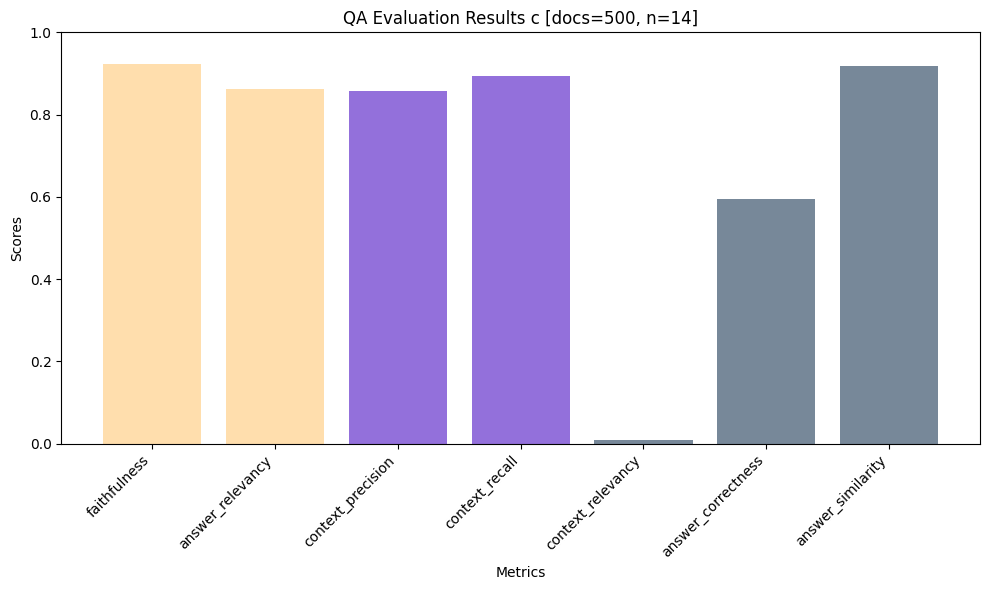

In [ ]:
# plot the result
import matplotlib.pyplot as plt

metrics = list(basic_qa_result.keys())
values = list(basic_qa_result.values())

colors = ['navajowhite', 'navajowhite',
          'mediumpurple', 'mediumpurple',
          'lightslategrey', 'lightslategrey', 'lightslategrey']

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=colors)
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('QA Evaluation Results c [docs=500, n=14]')
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)
plt.tight_layout()

plt.savefig('../data/plots/ragas_eval_c500.png')
plt.show()